In [3]:
import sys
sys.path.append("../..") 

In [4]:
import glob,os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [5]:
# args
RES_PATH = "../../experiments/simulations/data_size/"

In [14]:
def get_metrics_from_folder(path):
    df_tests = []
    for folder in os.listdir(path):
        if folder.startswith('.') == False:
            pathm = os.path.join(path, folder, "metrics.csv")
            pathc = os.path.join(path, folder, "checkpoints/")
            paths = os.path.join(path, folder, "settings.csv")
            # model name:
            for _, _, files in os.walk(pathc):
                file = [f for f in files if f.endswith('.ckpt')][0]
                chk_path = os.path.join(pathc,file)
            checkpoint = torch.load(chk_path)
            model_name = checkpoint["hyper_parameters"]['net']
            hidden_dim_t = checkpoint["hyper_parameters"]['hidden_dims']
            # sim settings
            settings = pd.read_csv(paths)
            # model results:
            df = pd.read_csv(pathm)
            df_test = df.loc[:,df.columns.str.startswith('test') | df.columns.str.startswith('int')]
            df_test = df_test.dropna()
            df_test.loc[:,'model'] = model_name
            df_test.loc[:,'N'] = settings.N.item()
            df_tests.append(df_test)
        df_test = pd.concat(df_tests, axis=0)
    return df_test

In [15]:
df_test = get_metrics_from_folder(RES_PATH)

{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}
{'hidden_dim_t': 10, 'hidden_dim_0': 0}


In [6]:
df_test.test_loss_pred = np.sqrt(df_test.test_loss_pred)
df_test.test_loss_update = np.sqrt(df_test.test_loss_update)

In [7]:
df_test

,test_loss,test_loss_pred,test_loss_update,test_rmse,model,N
511,0.001999,0.044301,0.019200,0.044301,ctGRUModel,5000
1485,0.001974,0.043996,0.019492,0.043996,neuralJumpModel,20000
1265,0.001929,0.043652,0.015209,0.043652,ctRNNModel,20000
672,0.001984,0.044101,0.019672,0.044101,ctRNNModel,10000
643,0.001944,0.043869,0.014059,0.043869,ctGRUModel,10000
5500,0.001925,0.043660,0.013518,0.043660,ctGRUModel,20000
511,0.002018,0.044396,0.021731,0.044396,ctRNNModel,5000
560,0.002092,0.044859,0.028171,0.044859,neuralJumpModel,10000
700,0.002063,0.044690,0.025615,0.044690,neuralJumpModel,5000
144,0.002930,0.051181,0.055751,0.051181,neuralJumpModel,1000


In [8]:
d = {'neuralJumpModel':'NJ-ODE','ctRNNModel':'ODE-RNN','ctGRUModel':'ODE-GRU'}

In [9]:
df_test['model_name'] = [d[m] for m in df_test.model]

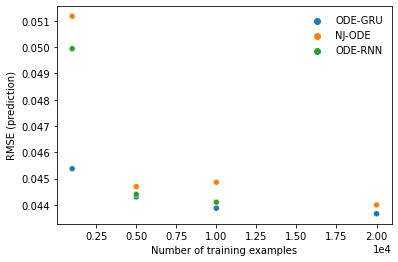

In [10]:
f, ax = plt.subplots()
sns.scatterplot(x="N", y="test_loss_pred", hue="model_name",data=df_test)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('RMSE (prediction)')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend(title="",frameon=False)
plt.show()

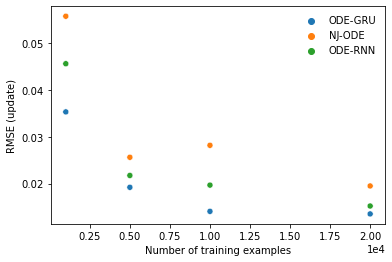

In [11]:
f, ax = plt.subplots()
sns.scatterplot(x="N", y="test_loss_update", hue="model_name",data=df_test)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('RMSE (update)')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.legend(title="",frameon=False)
plt.show()